In [ ]:
# default_exp inferno

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

Attempted reproduction INFERNO following paper description implementations with nuisances being approximated by creating up/down shapes and interpolating
Runs and reproduces some of the paper results

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from pytorch_inferno.callback import PredHandler

import numpy as np

import torch.nn as nn
from torch import Tensor

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn.functional as F
from torch import optim
import torch
from torch import autograd

# Network

In [ ]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [ ]:
# export
class VariableSoftmax(nn.Softmax):
    r'''Softmax with temperature'''
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [ ]:
x = torch.randn((1,10))

In [ ]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[4.4157e-09, 2.2224e-09, 1.0000e+00, 6.6416e-17, 9.1319e-12, 3.7735e-07,
          1.6735e-09, 3.6731e-14, 1.0835e-08, 7.5836e-16]]),
 tensor([[1.8634e-02, 1.6243e-02, 8.7358e-01, 5.0787e-04, 5.4127e-03, 4.5358e-02,
          1.5347e-02, 1.7960e-03, 2.2298e-02, 8.2656e-04]]),
 tensor([[0.0737, 0.0688, 0.5047, 0.0122, 0.0397, 0.1150, 0.0669, 0.0229, 0.0806,
          0.0155]]))

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [ ]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [ ]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [ ]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

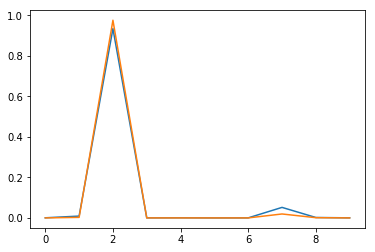

In [ ]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

## Minimise width

with torch.no_grad():
    u,d = [],[]
    b = x[m]
    b[:,0] += 0.2
    u.append(to_shape(net(b)))
    b[:,0] -= 0.2
    b[:,2] *= 3.5/3
    u.append(to_shape(net(b)))
    b[:,2] /= 3.5/3
    b[:,0] -= 0.2
    d.append(to_shape(net(b)))
    b[:,0] += 0.2
    b[:,2] *= 2.5/3
    d.append(to_shape(net(b)))
    b[:,2] /= 2.5/3
    b_up,b_dw = torch.stack(u),torch.stack(d)

nll,alpha = calc_profile(f_s=f_s, f_b_nom=f_b, f_b_up=b_up, f_b_dw=b_dw, verbose=False, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

nll

plot_likelihood(to_np(nll-nll[nll==nll].min()))

nll = nll-nll[nll==nll].min()-0.5

nll

plot_likelihood(to_np(nll))

nll.max()-nll.min()

def get_diff_width(nll:Tensor, mu_scan:np.ndarray) -> Tensor:
    def lin_root(nll0,nll1,mu0,mu1):
        a = (nll1-nll0)/(mu1-mu0)
        b = nll1-(a*mu1)
        return -b/a
    
    u,r,last_mu,last_nll = True,torch.zeros((2)),mu_scan[0],nll[0]

    for mu,l in zip(mu_scan[1:],nll[1:]):
        if u and l < 0:
            r[0] = lin_root(last_nll,l,last_mu,mu)
            u = False
        elif not u and l > 0:
            r[1] = lin_root(last_nll,l,last_mu,mu)
            break
        if l == l: last_mu,last_nll = mu,l
    return r[1]-r[0]

w = get_diff_width(nll, mu_scan=np.linspace(20,80,61)); w

class AbsInferno(AbsCallback):
    def __init__(self, n:int, mu_scan:Tensor, true_mu:int, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        r'''
        Fake loss function, callback computes loss in `on_forwards_end`
        '''
        self.wrapper.loss_func = lambda x,y: None
        self.profiler = partialler(calc_profile, n=self.n, mu_scan=to_device(self.mu_scan, self.wrapper.device), true_mu=self.true_mu,
                                   n_steps=self.n_steps, lr=self.lr, verbose=False)
        
    @staticmethod
    def _to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)
        f = f + 1e-7
        f = f/f.sum()
        return f
    
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]: pass
        
    def _get_diff_width(self, nll:Tensor) -> Tensor:
        def lin_root(nll0,nll1,mu0,mu1):
            a = (nll1-nll0)/(mu1-mu0)
            b = nll1-(a*mu1)
            return -b/a

        u,r,last_mu,last_nll = True,torch.zeros((2)),self.mu_scan[0],nll[0]
        for mu,l in zip(self.mu_scan[1:],nll[1:]):
            if u and l < 0:
                r[0] = lin_root(last_nll,l,last_mu,mu)
                u = False
            elif not u and l > 0:
                r[1] = lin_root(last_nll,l,last_mu,mu)
                break
            if l == l: last_mu,last_nll = mu,l
        return r[1]-r[0]
        
    def on_forwards_end(self) -> None:
        # Get sig. & bkg. shapes
        b = self.wrapper.y.squeeze()==0
        f_s = self._to_shape(self.wrapper.y_pred[~b])
        f_b = self._to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        
        # Compute nll
        nll,_ = self.profiler(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)
        try: nll = nll-nll[nll==nll].min()-0.5
        except RuntimeError: print(nll, self.wrapper.y_pred)
        w = self._get_diff_width(nll)
        print(w)
        print(self.wrapper.model[4].weight)
        self.wrapper.loss_val = torch.clamp_min(w, 0)

class PaperInferno(AbsInferno):
    def __init__(self, n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, n_steps:int=100, lr:float=0.1):
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, n_steps=n_steps, lr=lr)
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        with torch.no_grad():
            u,d = [],[]
            x[:,0] += 0.2
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] -= 0.2
            x[:,2] *= 3.5/3
            u.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 3.5/3
            x[:,0] -= 0.2
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,0] += 0.2
            x[:,2] *= 2.5/3
            d.append(self._to_shape(self.wrapper.model(x)))
            x[:,2] /= 2.5/3
            return torch.stack(u),torch.stack(d)

net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=nn.BCELoss(),
          cbs=[PaperInferno(),LossTracker(),EarlyStopping(5),GradClip(1e-5)])

model.save('weights/Inferno_Test.h5')

In [ ]:
class AbsInferno(AbsCallback):
    r'''Attempted reproduction INFERNO following paper description implementations with nuisances being approximated by creating up/down shapes and interpolating
    Runs and reproduces some of the paper results
    Includes option to randomise params per batch and converge to better values, but results in slightly worse performance'''
    def __init__(self, n:int, mu_scan:Tensor, true_mu:float, aug_alpha:bool=False, n_alphas:int=0, n_steps:int=100, lr:float=0.1):
        super().__init__()
        store_attr()
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
    
    @staticmethod
    def to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
        
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        r'''Compute upd/down shapes. Overide this for specific problem.'''
        pass
    
    def get_ikk(self, f_s:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor) -> Tensor:
        r'''Compute full hessian at true param values, or at random starting values with Newton updates'''
        if self.aug_alpha: alpha = torch.randn((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)/10
        else:              alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): alpha[0] += self.true_mu
        get_nll = partialler(calc_nll, s_true=self.true_mu, b_true=self.n-self.true_mu,
                             f_s=f_s, f_b_nom=f_b_nom[None,:], f_b_up=f_b_up, f_b_dw=f_b_dw)
        if self.aug_alpha:  # Alphas carry noise, optimise via Newton
            for i in range(self.n_steps):  # Newton optimise nuisances & mu
                nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
                g,h = calc_grad_hesse(nll, alpha)
                s = torch.clamp(self.lr*g.detach()@torch.inverse(h), -100, 100)
                alpha = alpha-s
        nll = get_nll(s_exp=alpha[0], alpha=alpha[1:])
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
        return torch.inverse(h)[0,0]
        
    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        self.wrapper.loss_val = self.get_ikk(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)

In [ ]:
class PaperInferno(AbsInferno):
    def __init__(self, r_mods:Optional[Tuple[float,float]]=(-0.2,0.2), l_mods:Optional[Tuple[float,float]]=(2.5,3.5), l_init:float=3,
                 n:int=1050, mu_scan:Tensor=torch.linspace(20,80,61), true_mu:int=50, aug_alpha:bool=False, n_steps:int=10, lr:float=0.1):
        r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
        super().__init__(n=n, mu_scan=mu_scan, true_mu=true_mu, aug_alpha=aug_alpha, n_alphas=(r_mods is not None)+(l_mods is not None), n_steps=n_steps, lr=lr)
        self.r_mods,self.l_mods,self.l_init = r_mods,l_mods,l_init
        
    def on_train_begin(self) -> None:
        if self.r_mods is not None:
            self.r_mod_t = (torch.zeros(1,3, device=self.wrapper.device),torch.zeros(1,3, device=self.wrapper.device))
            self.r_mod_t[0][0,0] = self.r_mods[0]
            self.r_mod_t[1][0,0] = self.r_mods[1]
        if self.l_mods is not None:
            self.l_mod_t = (torch.ones(1,3, device=self.wrapper.device),torch.ones(1,3, device=self.wrapper.device))
            self.l_mod_t[0][0,2] = self.l_mods[0]/self.l_init
            self.l_mod_t[1][0,2] = self.l_mods[1]/self.l_init
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        if self.r_mods is None and self.l_mods is None: return None,None
        u,d = [],[]
        if self.r_mods is not None:
            x = x+self.r_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x+self.r_mod_t[1]-self.r_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x-self.r_mod_t[1]
        if self.l_mods is not None:
            x = x*self.l_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x*self.l_mod_t[1]/self.l_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x/self.l_mod_t[1]
        return torch.stack(u),torch.stack(d)

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [ ]:
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(aug_alpha=False, n_steps=10),LossTracker(),SaveBest('weights/best_ii.h5'),EarlyStopping(10)])

1: Train=556.7987005615234 Valid=473.32949096679687
2: Train=471.1977426147461 Valid=456.1543841552734
3: Train=449.4684811401367 Valid=435.4875744628906
4: Train=428.7104479980469 Valid=421.1585504150391
5: Train=416.38864562988283 Valid=406.98321716308595
6: Train=402.5627383422852 Valid=399.2689447021484
7: Train=392.57822387695313 Valid=390.0374609375
8: Train=384.3989727783203 Valid=381.96501098632814
9: Train=377.2406292724609 Valid=376.0867645263672
10: Train=372.59075256347654 Valid=371.28949645996096
11: Train=368.34562042236325 Valid=365.384560546875
12: Train=362.73923645019534 Valid=362.89099975585935
13: Train=359.37135131835936 Valid=360.1908941650391
14: Train=356.50582916259765 Valid=356.41084655761716
15: Train=354.0604196166992 Valid=354.0810040283203
16: Train=351.0649749755859 Valid=352.3337860107422
17: Train=349.0106726074219 Valid=350.3598193359375
18: Train=346.6421122741699 Valid=348.2231811523437
19: Train=344.9382424926758 Valid=347.19819702148436
20: Train=3

156: Train=313.25415298461917 Valid=318.67429443359373
157: Train=312.9283708190918 Valid=318.2888836669922
158: Train=312.97928146362307 Valid=317.71422607421874
159: Train=312.4889096069336 Valid=318.4048425292969
160: Train=313.7785565185547 Valid=317.69529602050784
161: Train=312.6553202819824 Valid=317.638994140625
162: Train=312.2974041748047 Valid=318.2372064208984
163: Train=312.10514282226563 Valid=317.6021997070313
164: Train=312.5424540710449 Valid=317.78399536132815
165: Train=312.7284605407715 Valid=317.9670678710938
166: Train=312.0129473876953 Valid=317.80974670410154
167: Train=311.67784759521487 Valid=316.77385803222654
168: Train=312.3789028930664 Valid=317.7610717773438
169: Train=312.2655145263672 Valid=318.43058349609373
170: Train=312.39062301635744 Valid=317.3865106201172
171: Train=312.4671920776367 Valid=317.8665447998047
172: Train=311.7017126464844 Valid=316.9460760498047
173: Train=312.46403839111326 Valid=317.5543005371094
174: Train=311.08968795776366 Vali

In [ ]:
model.save('weights/Inferno_Test_interp_bm2.h5')

model.load('weights/Inferno_Test_interp_bm0.h5')

# Results

In [ ]:
# export
class InfernoPred(PredHandler):
    r'''Prediction handler for hard assignments'''
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)

## BM 0

In [ ]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [ ]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,6,1.0
1,6,1.0
2,6,1.0
3,6,1.0
4,6,1.0


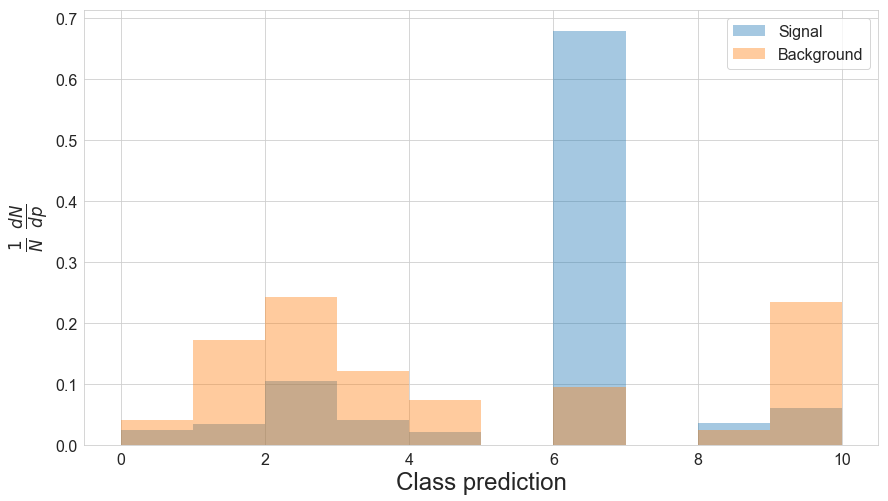

In [ ]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,6,1.0,6
1,6,1.0,6
2,6,1.0,6
3,6,1.0,6
4,6,1.0,6


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [ ]:
f_s, f_b

(tensor([5.8150e-02, 1.0425e-01, 4.0168e-02, 2.1380e-02, 2.0000e-13, 6.7885e-01,
         2.0000e-13, 3.6114e-02, 6.1082e-02, 2.0000e-13]),
 tensor([2.1191e-01, 2.4181e-01, 1.2033e-01, 7.3938e-02, 2.0000e-13, 9.4530e-02,
         2.0000e-13, 2.3886e-02, 2.3360e-01, 2.0000e-13]))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([2.1482e+02, 2.4702e+02, 1.2234e+02, 7.5007e+01, 2.1000e-10, 1.2847e+02,
         2.1000e-10, 2.5692e+01, 2.3665e+02, 2.1000e-10]), tensor(1050.))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([25.09990311, 24.97018051, 24.84552383, 24.72616196, 24.61150742,
       24.50212479, 24.39759445, 24.29800415, 24.20287704, 24.11277771,
       24.02714157, 23.94638062, 23.8701973 , 23.79827881, 23.73109055,
       23.668293  , 23.60976028, 23.55553055, 23.50559616, 23.46014786,
       23.41863251, 23.38126755, 23.34797668, 23.31922531, 23.29408264,
       23.27286911, 23.25563049, 23.24235153, 23.23277664, 23.22732925,
       23.22544479, 23.22711563, 23.23276138, 23.24211502, 23.25491714,
       23.27124023, 23.29117203, 23.31478882, 23.34180069, 23.37220764,
       23.40602493, 23.44325256, 23.4837532 , 23.52778244, 23.57474136,
       23.62533188, 23.67873001, 23.73566055, 23.79553604, 23.85865402,
       23.92491913, 23.99419022, 24.06642914, 24.14204788, 24.22027588,
       24.30145645, 24.38577271, 24.47270584, 24.56296921, 24.65579605,
       24.75135422])

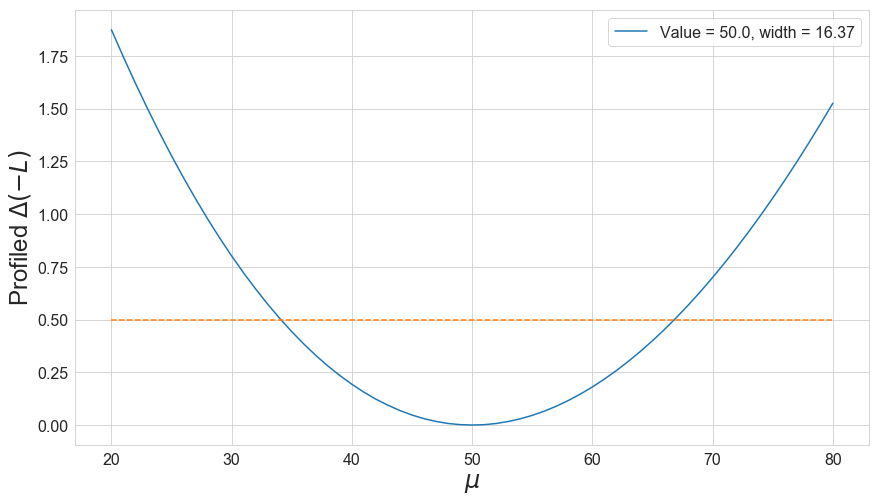

In [ ]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,6,1.0,6,6,6,6,6,6,6,6,6,6,6
1,6,1.0,6,6,6,6,6,6,6,6,6,6,6
2,6,1.0,6,6,6,6,6,6,6,6,6,6,6
3,6,1.0,6,6,6,6,6,6,6,6,6,6,6
4,6,1.0,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,9,0.0,9,9,9,9,9,9,9,9,9,9,9
999996,9,0.0,9,9,9,9,9,9,9,9,9,2,2
999997,6,0.0,6,6,6,6,6,6,6,6,6,6,6
999998,1,0.0,1,1,1,1,1,1,1,9,9,1,1


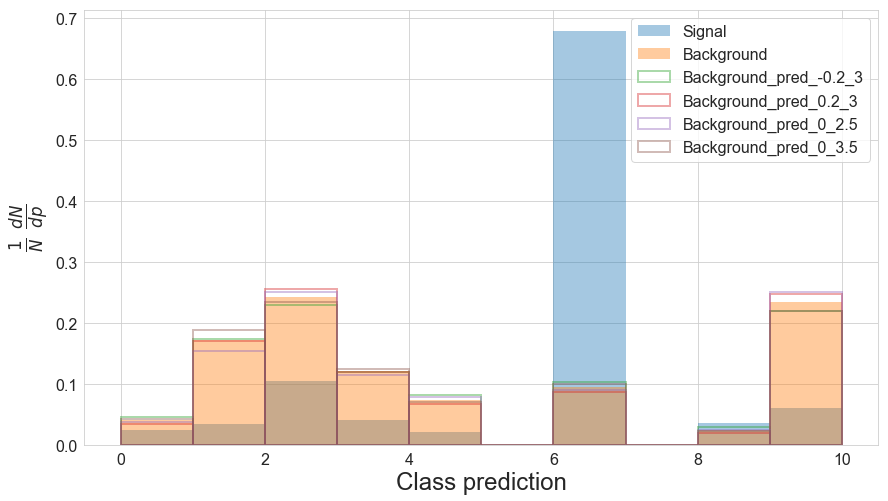

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([1.9896e-01, 2.3756e-01, 1.1414e-01, 8.6292e-02, 2.0000e-13, 9.7904e-02,
        2.0000e-13, 2.8982e-02, 2.3617e-01, 2.0000e-13])
tensor([2.1894e-01, 2.2871e-01, 1.1995e-01, 8.1594e-02, 2.0000e-13, 1.0246e-01,
        2.0000e-13, 2.8528e-02, 2.1983e-01, 2.0000e-13])
tensor([2.3793e-01, 2.2028e-01, 1.2458e-01, 7.7346e-02, 2.0000e-13, 1.0714e-01,
        2.0000e-13, 2.8006e-02, 2.0473e-01, 2.0000e-13])
tensor([1.9193e-01, 2.5066e-01, 1.1452e-01, 7.8636e-02, 2.0000e-13, 8.9972e-02,
        2.0000e-13, 2.4340e-02, 2.4994e-01, 2.0000e-13])
tensor([2.1191e-01, 2.4181e-01, 1.2033e-01, 7.3938e-02, 2.0000e-13, 9.4530e-02,
        2.0000e-13, 2.3886e-02, 2.3360e-01, 2.0000e-13])
tensor([2.3090e-01, 2.3338e-01, 1.2496e-01, 6.9690e-02, 2.0000e-13, 9.9204e-02,
        2.0000e-13, 2.3364e-02, 2.1850e-01, 2.0000e-13])
tensor([1.8523e-01, 2.6368e-01, 1.1388e-01, 7.1830e-02, 2.0000e-13, 8.2054e-02,
        2.0000e-13, 2.0094e-02, 2.6324e-01, 2.0000e-13])
tensor([2.0521e-01, 2.5483e-01, 1.1969e-0

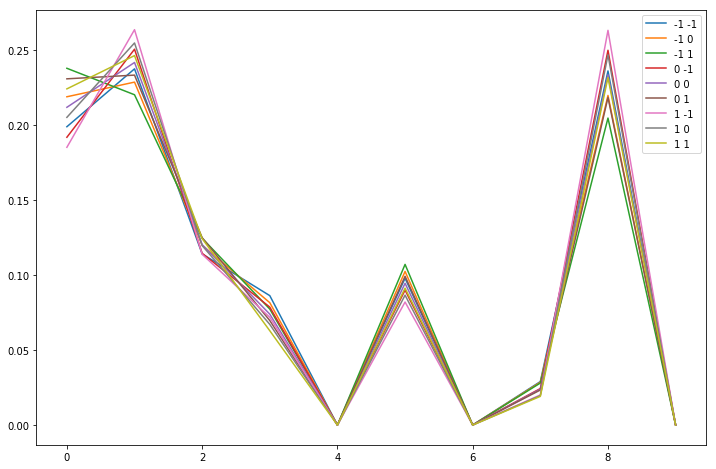

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [ ]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [ ]:
nll = to_np(nll)

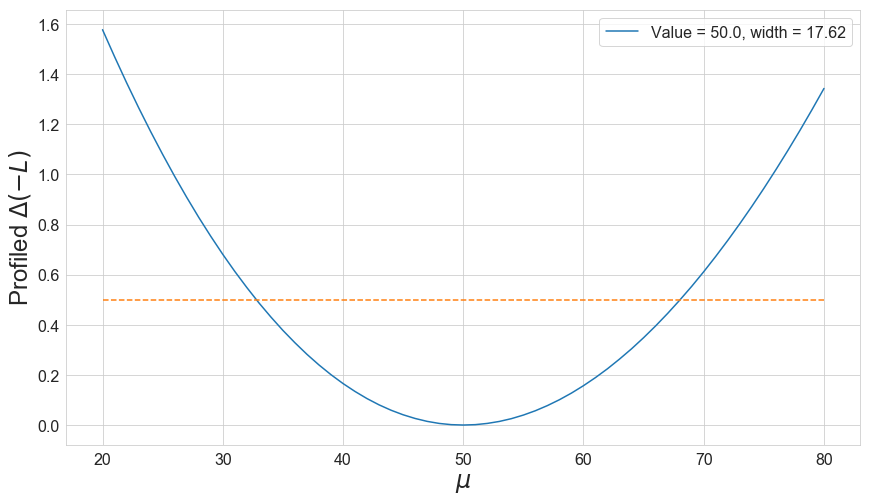

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [ ]:
nll = to_np(nll)

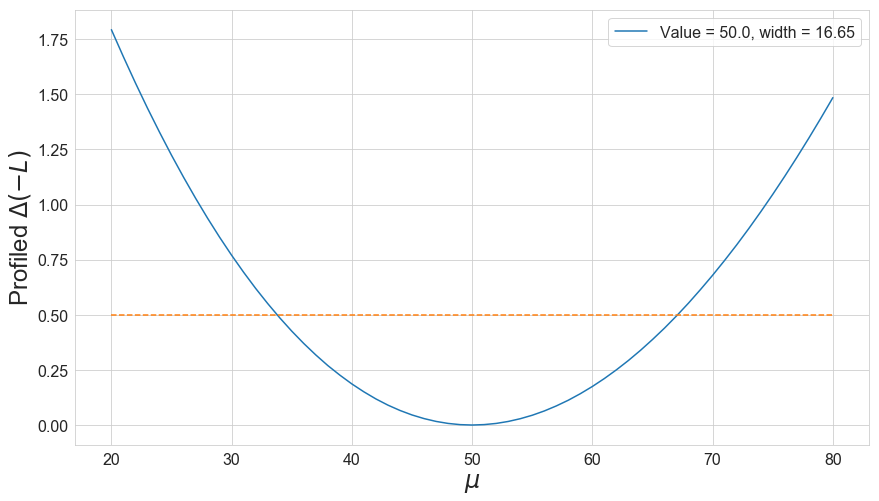

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [ ]:
nll = to_np(nll)

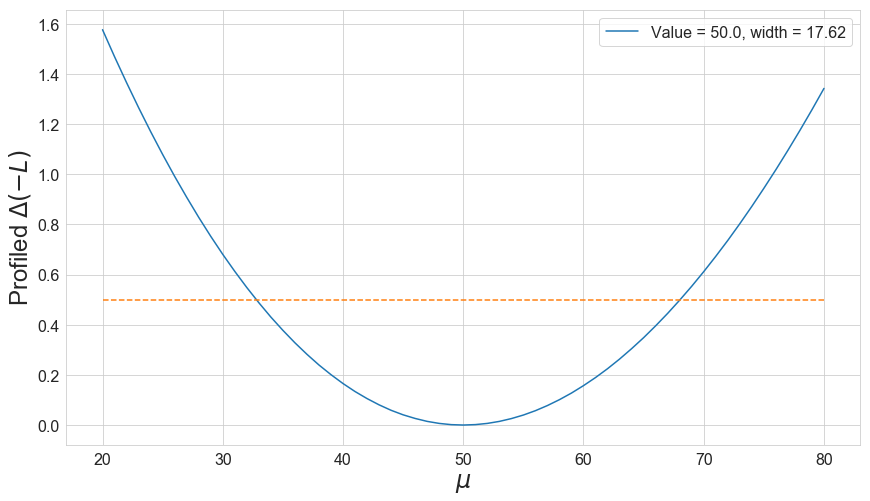

In [ ]:
plot_likelihood(nll-nll.min())